## 3.1 Predicting 3D gene expression profiles and cell-to-cell mappings

#### 1. Loading required libraries

In [ ]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
base_dir="/home/jovyan/storage"
os.chdir(base_dir)
sys.path.append(base_dir + "/source")
import expression_prediction.spatial_gene_expression_prediction as gep
import visualize_3d_gene_expression.plotting_functions as pl

#### 2. Setting paths to the data

In [6]:
dge_path = base_dir + "/data/dge_day4_Oct-Nofilter_downsize.csv"
coord_path = base_dir + "/data/confocal_states0-FilterWUSCLVtop100.csv"
out_base_path = base_dir + "/data"

#### 3. Setting the parameters

In [4]:
verbose=True
keep_genes=["AT2G17950", "AT2G27250"] 
genes_remove_list=[] 
pre_mode = "expr_pre" # or pre_mode = "cell_mapping"
ns=4 # num_neighbors_source
nt=4 # num_neighbors_target
ap=0.1 # alpha
ep=0.05 # epsilon
tr="none" # transform
md="euclidean" # method_dist
ts=50 # top_sccells
tc=100 # top_cor_genes
mi=5000 # max_iter
to=1e-9 # tol
ms=50 # min_sccells_gene_expressed
ce=False # cell_enrichment

#### 5. Loading the required data

In [7]:
dge, gene_names, cell_ids = gep.load_scDGE(dge_path=dge_path)
sem = gep.load_spatial_expression_matrix(coord_path=coord_path)

#### 6. A quick way to predict 3D gene expression profiles and cell-mappings

In [8]:
sdge = gep.predict_3D_gene_expression(
                              min_sccells_gene_expressed=ms, keep_genes=keep_genes, genes_remove_list=genes_remove_list,
                              method_dist=md, top_sccells=ts, enrich=ce,
                              num_neighbors_target=nt, num_neighbors_source=ns, top_cor_genes=tc,
                              transform=tr, alpha=ap, epsilon=ep, max_iter=mi, tol=to, verbose=verbose,
                              dge=dge, gene_names=gene_names, sem=sem)

no enrichment
529
Setting up for reconstruction ... done ( 0.9 seconds )
It.  |Err         
-------------------
    0|8.469096e-05|


In [9]:
gw = gep.predict_cell_mappings(
                              min_sccells_gene_expressed=ms, keep_genes=keep_genes, genes_remove_list=genes_remove_list,
                              method_dist=md, top_sccells=ts, enrich=ce,
                              num_neighbors_target=nt, num_neighbors_source=ns, top_cor_genes=tc,
                              transform=tr, alpha=ap, epsilon=ep, max_iter=mi, tol=to, verbose=verbose,
                              dge=dge, gene_names=gene_names, cell_ids=cell_ids, sem=sem)

no enrichment
529
Setting up for reconstruction ... done ( 2.16 seconds )
It.  |Err         
-------------------
    0|4.644337e-05|


#### 7. Pre-process the data

In [21]:
dge, genes_name_keep = gep.pre_process_scDGE(dge, gene_names=gene_names, 
                                             min_sccells_gene_expressed=ms, 
                                             keep_genes=keep_genes)
insitu_matrix, coord, sel_genes = gep.pre_process_spatial_expression_matrix(sem=sem, 
                                                                            genes_name_keep=genes_name_keep, 
                                                                            genes_remove_list=genes_remove_list)
index_genes = gep.get_idx_ref_genes_in_scDGE(dge=dge, 
                                             genes_name_keep=genes_name_keep, 
                                             sel_genes=sel_genes)

#### 8. Selection and Enrichment of cells

In [22]:
topcells = gep.get_best_cells(dge=dge, 
                              index_genes=index_genes, 
                              insitu_matrix=insitu_matrix, 
                              method_dist=md, 
                              top_sccells=ts, 
                              enrich=ce)

no enrichment
529


#### 9. Finding informative features in scRNA-seq DGE

In [23]:
dge_hvg = gep.subset_dge_to_informative_features(dge=dge, 
                                                 topcells=topcells, 
                                                 sel_genes=sel_genes, 
                                                 genes_name_keep=genes_name_keep, 
                                                 top_cor_genes=tc, 
                                                 pre_mode=pre_mode)

#### 10. Calculation of cost matrices

In [24]:
cost_expression, cost_locations = gep.get_expression_location_cost(dge_hvg=dge_hvg, 
                                                                   coord=coord, 
                                                                   ns=ns, 
                                                                   nt=nt)
cost_marker_genes = gep.get_marker_gene_cost(dge=dge, 
                                             insitu_matrix=insitu_matrix, 
                                             pre_mode=pre_mode, 
                                             method_dist=md, 
                                             tr=tr, 
                                             index_genes=index_genes, 
                                             topcells=topcells)

Setting up for reconstruction ... done ( 0.88 seconds )


#### 11. Calculate distribution over cells

In [25]:
p_locations, p_expression = gep.get_distributions_over_expression_location(dge_hvg=dge_hvg, 
                                                                           coord=coord)

#### 12. Predict cell-to-cell mappings

In [28]:
gw = gep.predict_cell_to_cell_mappings(cost_marker_genes=cost_marker_genes, 
                                       cost_expression=cost_expression,
                                       cost_locations=cost_locations, 
                                       p_expression=p_expression, 
                                       p_locations=p_locations, 
                                       alpha=ap, 
                                       epsilon=ep, 
                                       max_iter=mi, 
                                       tol=to, 
                                       verbose=verbose)

It.  |Err         
-------------------
    0|8.469096e-05|


#### 13. Predict 3D gene expression profiles

In [29]:
sdge = gep.predict_spatial_gene_expression(gw=gw, 
                                           dge=dge, 
                                           topcells=topcells, 
                                           pre_mode=pre_mode)

#### 14. Prepare results

In [30]:
cell_ids_sel = cell_ids[topcells]
gw = round(pd.DataFrame(gw, index=cell_ids_sel), 3)

sdge = np.transpose(sdge)
sdge = np.concatenate((coord, sdge), axis=1)
col_names = np.concatenate((np.array(["x", "y", "z"]), genes_name_keep), axis=0)
sdge = round(pd.DataFrame(sdge, columns=col_names), 3)

#### Save results

In [33]:
gw.to_csv(out_base_path + "/cell-to-cell_mapping.csv", index=True, header=True, sep=',')
sdge.to_csv(out_base_path + "/sdge.csv", index=True, header=True, sep=',')

## 3.2 Visualizing 3D gene expression profiles

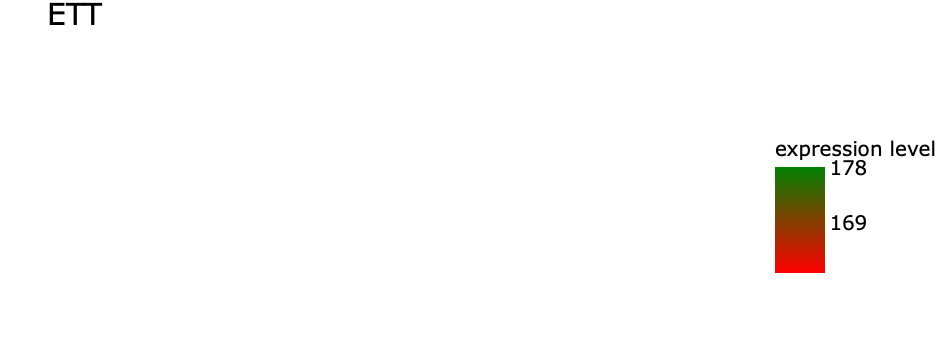

In [34]:
st = {"ETT":"AT2G33860", "STM":"AT1G62360", "CO2":"AT1G62500"}
gene_symbol="ETT"
col_code = ["red","green"]
fig = pl.plot_3d_meristem(df=sdge, gene = st[gene_symbol], colorscale = col_code, plot_title = gene_symbol, show_legend=True, backgrnd_col="white", font_col="black", legend_title="expression level")
fig

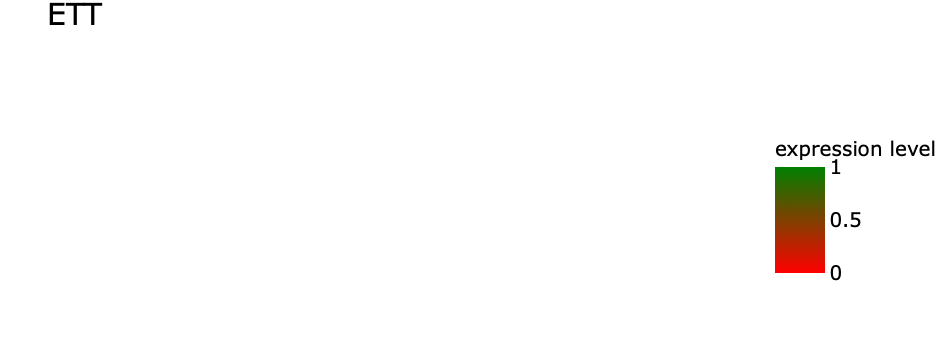

In [35]:
fig = pl.plot_3d_meristem(df=sem, gene = st[gene_symbol], colorscale = col_code, plot_title = gene_symbol, show_legend=True, backgrnd_col="white", font_col="black", legend_title="expression level")
fig

## 3.3 Projecting scRNA-seq clusters onto the 3D meristem
--> via notebook “3 - UMAP_cluster_projection”

## 3.4 Visualizing scRNA-seq clusters in the 3D flower meristem

In [36]:
path = base_dir + "/data/cluster_assignment_3d.csv"
m = pd.read_csv(path, sep=",", index_col=0, decimal=".") # (cells x genes)

path = base_dir + "/data/seurat_cell_meta_data.csv"
umap = pd.read_csv(path, sep=",", index_col=0, decimal=".") # (cells x UMAP_coordinates)

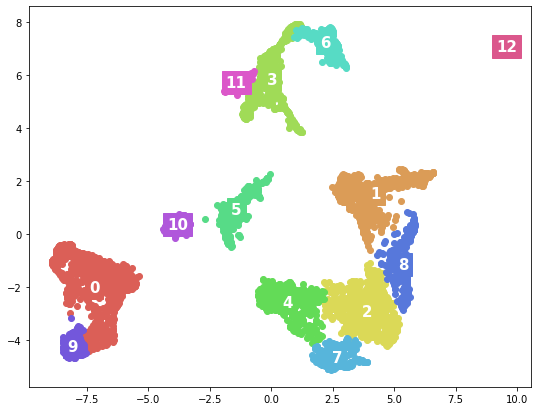

In [37]:
pl.plot_umap(umap=umap, plot_size_x=9, plot_size_y=7, label_size=15)

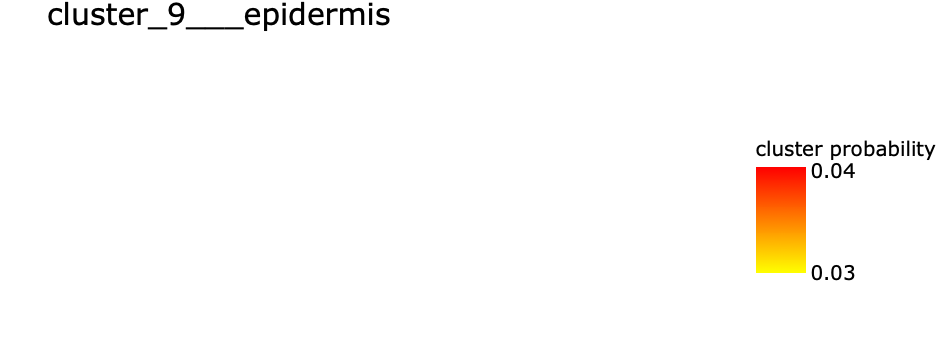

In [38]:
col_code = ["yellow", "red"]
cluster_name = "cluster_9___epidermis"
fig = pl.plot_3d_meristem(df=m, gene = cluster_name, colorscale = col_code, plot_title = cluster_name, show_legend=True, backgrnd_col="white", font_col="black", legend_title="cluster probability")
fig

## 3.5 Evaluating prediction performance (AUCROC and PEP-score)
The calculation of PEP-scores can be done via the notebook “5 - Evaluate Prediction Performance”.